In [1]:
# Import all the necessary files!
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

In [19]:
# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(weights = "imagenet",
    input_shape=(150, 150, 3),
    include_top=False,
)

# Making all layers non trainable
for layer in pre_trained_model.layers:
  layer.trainable = False

# Print the model summary
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

In [21]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [26]:
# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True


In [27]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)

x = layers.Dense(1024, activation='relu')(x)

x = layers.Dropout(.2)(x)                  

x = layers.Dense(1, activation='sigmoid')(x)           

model = Model(pre_trained_model.input, x) 

model.compile(
    optimizer=RMSprop(lr=0.0001), 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [28]:
# Get the Horse or Human dataset
!python -m wget https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip -o tmp/horse-or-human.zip

# Get the Horse or Human Validation dataset
!python -m wget https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip -o tmp/validation-horse-or-human.zip 


Saved under tmp/horse-or-human (1).zip

Saved under tmp/validation-horse-or-human (1).zip


In [29]:
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

local_zip = 'tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp/training')
zip_ref.close()

local_zip = 'tmp/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp/validation')
zip_ref.close()

In [30]:
# Define our example directories and files
train_dir = 'tmp/training'
validation_dir = 'tmp/validation'

train_horses_dir = os.path.join(train_dir, 'horses') 
train_humans_dir = os.path.join(train_dir, 'humans') 
validation_horses_dir = os.path.join(validation_dir, 'horses')
validation_humans_dir = os.path.join(validation_dir, 'humans')

train_horses_fnames = os.listdir(train_horses_dir)
train_humans_fnames = os.listdir(train_humans_dir)
validation_horses_fnames = os.listdir(validation_horses_dir)
validation_humans_fnames = os.listdir(validation_humans_dir)

print(len(train_horses_fnames))
print(len(train_humans_fnames))
print(len(validation_horses_fnames))
print(len(validation_humans_fnames))

500
527
128
128


In [31]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale = 1./255.,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(
    rescale = 1./255.
)

# Flow training images  using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=64,
    class_mode='binary',
    target_size=(150,150)
)     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(
    validation_dir,
    batch_size=64,
    class_mode='binary',
    target_size=(150,150)
)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [32]:
callbacks = myCallback()
history = model.fit_generator(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[callbacks]
)

C:\Users\gopal\anaconda3\envs\tf2.4\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
17/17 [==============================] - 28s 1s/step - loss: 0.4929 - accuracy: 0.8114 - val_loss: 0.0126 - val_accuracy: 0.9961
Epoch 2/50
17/17 [==============================] - 12s 741ms/step - loss: 0.0320 - accuracy: 0.9885 - val_loss: 0.0253 - val_accuracy: 0.9922
Epoch 3/50
17/17 [==============================] - 12s 713ms/step - loss: 0.0192 - accuracy: 0.9933 - val_loss: 0.0512 - val_accuracy: 0.9805
Epoch 4/50
17/17 [==============================] - 12s 724ms/step - loss: 0.0586 - accuracy: 0.9796 - val_loss: 0.0037 - val_accuracy: 0.9961
Epoch 5/50
17/17 [==============================] - 13s 745ms/step - loss: 0.0107 - accuracy: 0.9976 - val_loss: 0.0238 - val_accuracy: 0.9922
Epoch 6/50
17/17 [==============================] - 12s 725ms/step - loss: 0.0059 - accuracy: 0.9975 - val_loss: 0.0581 - val_accuracy: 0.9844
Epoch 7/50
17/17 [==============================] - 13s 767ms/step - loss: 0.0184 - accuracy: 0.9915 - val_loss: 0.0443 - val_accuracy: 0.9883
Ep

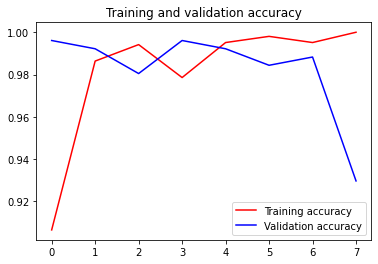

<Figure size 432x288 with 0 Axes>

In [34]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()